In [78]:
import sys, os

EDL_DIR = os.getcwd() # used to allow easy saving on any computer 
DOC = os.path.dirname(EDL_DIR)
sys.path.append("./EntryGuidance")
DIS_Images = os.path.join(EDL_DIR,"Documents", "Dissertation", "Images")
Paper_Images = os.path.join(EDL_DIR,"Documents", "PropellantOptimalJournal", "ddp", "python")
from scipy.interpolate import interp1d
from scipy.integrate import odeint, cumtrapz 
from scipy.io import loadmat, savemat
from scipy.stats import norm as normal

import pickle
from time import time

import numpy as np
import chaospy as cp
import pandas as pd
import matplotlib.pyplot as plt 

from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
from Utils.submatrix import submatrix 
from Utils import Unscented 
from Utils import MCF
from Utils import smooth
from Utils import draw

from EntryGuidance.EntryEquations import Entry, EDL
from EntryGuidance.Simulation import Simulation, Cycle, EntrySim
from EntryGuidance.InitialState import InitialState
from EntryGuidance.Planet import Planet 
from EntryGuidance.Triggers import AltitudeTrigger
from EntryGuidance.VMC import VMC, velocity_trigger
from EntryGuidance.EntryVehicle import ConstantAeroEV, LoDAeroEV

np.set_printoptions(suppress=True, precision=3)

# Monte Carlo Filtering Functions for Analysis

In [2]:
def range_error(xf, mean, mean_error):
    err = np.abs(xf[1] - mean)  # absolute error
    return err < mean_error # behavioral when error is less than the mean

def MCAnalyze(inputs, xf):
    mean = np.mean(xf[:,1], axis=0)
    err = np.mean(np.abs(xf[:,1] - mean))  #mean of absolute error
    
    data = MCF.mcsplit(inputs, xf, lambda x: range_error(x, mean, err))
    MCF.mcfilter(*data, plot=True, input_names=['h0','s0','v0','fpa0','CD','CL','rho'], ks_threshold=0, p_threshold=0.3)

In [3]:
Planet().atmosphere(np.linspace(10e3, 120e3, 500))[1].mean()

193.87863486973947

# DDP Controller Definition

In [3]:
def smooth_sat(x, tuning=20, safe=True):
    """Another saturation function, from 
    Saturated Robust Adaptive Control for Uncertain Nonlinear Systems using a new approximate model
    
    """
    q = 2*x-1
    q = 0.5 + 0.25/tuning*np.log(np.cosh(tuning*(q+1))/np.cosh(tuning*(q-1)))
    if safe:
        q[np.invert(np.isfinite(q))] = np.clip(x, 0, 1)[np.invert(np.isfinite(q))] # use hard clipping whenever the smooth approx causes nan/inf 
    return q

class ddp_controller:

    def __init__(self, data, safe=True):
        self.safe_saturate = safe
        v = data['v'].squeeze()
        u0 = data['u'].copy() # feedfoward term 
        if len(u0.shape)>1 and u0.shape[0]>1:
            if data['u'].shape[0] == 2:
                print('Fixed Gain + Overcontrol')
                G = data['input']['gains'].squeeze()
                k = np.array([data['u'][1]*g for g in G])
                K = interp1d(v[:-1], k, bounds_error=False, fill_value=(k[:,-2], k[:,0]))
            else:
                K = interp1d(v[:-1], data['u'][1:], bounds_error=False, fill_value=(data['u'][1:,-2], data['u'][1:,0]))
            u0 = u0[0]

        else:
            if 'gains' in data:
                G = data['gains'].squeeze()
            else:
                G = data['input']['gains'].squeeze()
#             G[2] = np.clip(G[2], -10, 10)
            K = lambda v: G
            print("Fixed Gain Controller, ", G)
        
        u0[-1] = u0[-2]
        u0 = np.append(u0, u0[-2])    
        u0 *= data['Lm']/data['Dm'] # converts to reference L/D, more robust 
        self.K = K
        self.u = interp1d(v, u0, bounds_error=False, fill_value=(u0[-1],u0[0]))
        xr = np.vstack([data['Dm'], data['mean'][1:]])
        self.ref = interp1d(v, xr, bounds_error=False, fill_value=(xr[:,-1],xr[:,0]))
        
        self.previous = None 

    def __call__(self, E, x, L, D, saturate=True):
        # This function is used in VMC to generate the controls
        
        # compute error states, apply gains
        if len(x) == 5:
            r,s,v,fpa,_ = x
        else:
            r,s,fpa,_ = x
            v = E
        
        xr = self.ref(v)
        eD = D - xr[0]
        es = s/1000 - xr[2]
        ef = fpa - xr[1]
        K = self.K(v)
        if 0:
            print(K)
#             print(eD, es, np.degrees(ef))
#             print(xr)
        u = self.u(v)*D/L + K[0]*eD + K[1]*es + K[2]*ef
        if saturate:
#             u = np.clip(u, 0, 1)
            u = smooth_sat(u, safe=self.safe_saturate)
#             u[np.isnan(u)] = np.clip(self.u(v)*D/L + K[0]*eD + K[1]*es + K[2]*ef, 0, 1)[np.isnan(u)] # replaces nan controls w/ hard clipping
        
#         u = np.clip(self.u(v) + K[0]*eD + K[1]*es + K[2]*ef, 0, 1)
        
#         u[np.isnan(u)] = 1
        
        return u
    

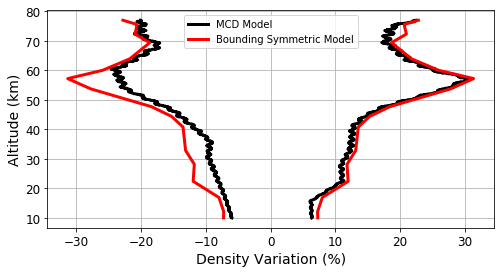

In [34]:
hn = [79.7748,77.5504,72.2886,68.4254,60.3705,53.733,46.2886,36.0685,30.8075,17.2535,9.50723,-0.190357]
rhon = [-16.9185, -19.4075, -19.9728, -16.897, -23.7858, -22.239, -14.7454, -9.16435, -9.53793, -7.01905,-5.85366,-8.13663]
hp = [78.9612,74.8622,69.9182,63.8565,59.9912,57.221,53.6613,47.65,44.363,40.7958,32.8247,28.1564,22.3824,15.8032,5.90545,0.107413]
rhop = [24.8495,18.5303,17.3733,20.8044,25.0047,30.3547,26.714,17.331,14.2647,12.5366,12.1389,10.7912,10.9715,6.17758,6.35002,12.6505]

density_n = interp1d(hn, rhon)
density_p = interp1d(hp, rhop)
h = np.linspace(10, 77, 1000)
s1 = h/120 * (np.sin(np.pi*h) + np.random.random(np.size(h)))
M = 10
s2 = M + 7*np.sin(h/10)
# plt.plot(s2 + s1, h)
# plt.plot(-s2 - s1, h)

lw = 3
fs = 14
plt.figure(figsize=(8,4))
plt.plot(density_n(h) - s1, h, 'k', label='MCD Model', linewidth=lw)
plt.plot(density_p(h) + s1, h, 'k', linewidth=lw)

D = np.maximum(np.abs(density_n(h)), density_p(h)) + 1
plt.plot(D, h, 'r',label='Bounding Symmetric Model', linewidth=lw)
plt.plot(-D, h ,'r', linewidth=lw)
plt.xlabel('Density Variation (%)', fontsize=fs)
plt.ylabel('Altitude (km)', fontsize=fs)
plt.grid(True)
plt.legend(loc='best')
plt.gca().tick_params(axis='both', which='major', labelsize=fs-2)

# plt.savefig("./Documents/Dissertation/Images/DensityVariations",bbox_inches='tight')

# plt.plot()

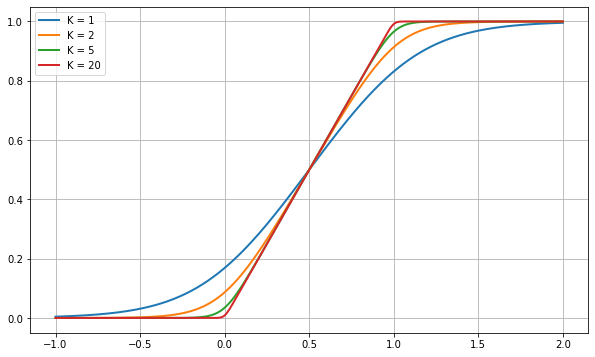

In [5]:
x = np.linspace(-1, 2, 1000)

plt.figure(figsize=(10,6))
for K in [1,2,5,20]:
    plt.plot(x, smooth_sat(x,K), label='K = {}'.format(K), linewidth=2)
plt.grid(1)
plt.legend()
# plt.savefig("./Documents/Seminar/smooth_saturation",bbox_inches='tight')
plt.show()

# Monte Carlo Functions

In [124]:
v = [ 6000, 4992.512,3996.452,2519.6536,1890.0615,1352.2175,1203.1013,517.1026,0]
LoD = [0.2375, 0.23756167,0.24493533,0.26297614,0.27370104,0.29312414,0.27746123,0.33886394,0.33886]
M = np.array(v)/200
lodfun = interp1d(M, LoD)

def UTStats(X, w):
    # want the entire cov matrix, so X should be vectors ns x n??
    X = np.asarray(X)
    M = np.array([w.dot(x) for x in X])
    C = np.sum([wi*np.outer(x-M, x-M) for x,wi in zip(X.T,w)], axis=0)
    return M,C

def data_loader(fname):
    return loadmat(os.path.join(DOC, 'GitHub\\Research\\Matlab\\', fname), squeeze_me=True) 

def build_dict(sol):
    """ Matlab mat files get loaded with a weird dtype and as zero-length arrays,
    this utility builds a standard python dict that is easier to work with and handles recursive structures"""
    output = {}
    
    for name in sol.dtype.names:
        if isinstance(sol[name][()], (float,int)) or sol[name][()].dtype.names is None:
            output[name] = sol[name][()]
        else:
            output[name] = build_dict(sol[name][()])
    return output

def MonteCarlo(data, N=2000, debug=False, parametric=True, sample='L'):
    """ Runs a monte carlo from a DDP solution and compares to UT results
    
        debug = True runs the unscented transform points to ensure those match 
    """
    print("\nWeights: {}".format(data['input']['weights']))
    P0 = data['input']['P0']  # h fpa s (no velocity term) 
    
    s_target = data['mean'][2,-1]
    print("Downrange Target = {:.3f} km".format(s_target))
    try:
        mass = data['mass'] # was hard coded 5000
        area = data['area']
        cd = data['cd']
        cl = data['cl']
    except:
        mass = 5000
        area = 16.1781
        cd = 1.3736
        cl = 0.3986      
        print("No mass/aero data in input, using 5000 kg")

    x0 = data['mean'].T[0]
    if debug:
        N = 7
        X0 = np.reshape(data['X0'].squeeze(), (3,N))
        X0[2] *= 1000 # data is in km, need meters 
        
    else:
        X0 = cp.MvNormal(x0, P0).sample(N, sample)

#     if len(data['v'][0]) > 1:
#         data['v'] = np.squeeze(data['v'][0])

    # reorder and add velocity terms - h s v gamma
    X0 =np.array([X0[0]+3396.2e3, X0[2], data['v'][0] + 0*X0[0], X0[1], mass + 0*X0[0]]) 
    
    mc = VMC()
    mc.null_sample(N)
    if parametric:
        mc.sample(N) # TODO: reset to zero whichever ones we aren't modeling in Matlab
        mc.samples[3] = 0 # no scale height variations 

    mc.control = ddp_controller(data)
    mc.set_trigger(velocity_trigger(data['v'][-1]))
    
#     vehicle = lambda CD,CL: ConstantAeroEV(1.3736, 0.3986, CD=CD, CL=CL, area=16.1781)
    if mass == 5000: # heavy vehicle with constant aero 
        print("Heavy vehicle with constant aero, L/D={}".format(cl/cd))
        vehicle = lambda CD,CL: ConstantAeroEV(cd, cl, CD=CD, CL=CL, area=area)
    else:
        print("MSL vehicle with specified L/D")
        vehicle = lambda CD,CL: LoDAeroEV(lodfun, cd, CD=CD, CL=CL, area=area)

    
    mc._run(X0, stepsize=[5, 0.1, 1], Ef=2000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})

#     keep = np.isfinite(mc.xf)
#     xf = np.reshape(mc.xf[keep], (-1,5))
    xf = mc.xf
    mean = np.mean(xf, axis=0)
    std = np.std(xf, axis=0)
    
    mc.target_range = s_target
    range_error = xf.T[1]/1000 - s_target # verify units
    range_error_mean = np.mean(range_error)
    range_error_3s = 3*np.std(range_error)
    h = xf.T[0]/1000-3396.2
    hm = np.mean(h)
    hs = np.std(h)
    h1 = np.percentile(xf.T[0]/1000-3396.2, 1)
    h99 = np.percentile(xf.T[0]/1000-3396.2, 99)
    s1 = np.percentile(np.abs(range_error), 1)
    s99 = np.percentile(np.abs(range_error), 99)
    print("1% altitude = {:.3f} km".format(h1))
    print("99% range error = {:.3f} km".format(s99))

    stochastic = 'var' in data
    if stochastic:
        hlow = data['mean'][0,-1]/1000 - 3*data['var'][0,-1]**0.5/1000
        std_ddp = [data['mean'][0,-1]/1000, hlow, 3*data['var'][2,-1]**0.5]
    else:
        print("Nominal opt, setting DDP mean/var to zeros")
        std_ddp = [0,0,0]
    if debug:
        print("Running in debug mode to recreate the unscented trajectories, disregard the MC values below")
    print("Mean range error = {:.2f} km".format(range_error_mean))        
    print("Mean Altitude\n\tDDP: {:.3f} km\n\tMC:  {:.3f} km".format(std_ddp[0], mean[0]/1000-3396.2))
    print("3-sigma Low Altitude\n\tDDP: {:.3f} km\n\tMC:  {:.3f} km".format(std_ddp[1], mean[0]/1000-3396.2-3*std[0]/1000))
    print("3-sigma DR Error\n\tDDP: {:.3f} km\n\tMC:  {:.3f} km".format(std_ddp[2], range_error_3s))        
    output = np.array([std_ddp[1],  mean[0]/1000-3396.2-3*std[0]/1000, std_ddp[2], range_error_3s]) # hlow_ddp hlow_mc, 3s_ddp 3s_mc
    
    UT_table = pd.DataFrame(data=np.array([[std_ddp[0], data['var'][0,-1]**0.5/1000, 0, 0],[s_target, data['var'][2,-1]**0.5,0,0]]),index=['UT Altitude','UT Range'],columns=['mean','std','1%','99%'])
    MC_table = pd.DataFrame(data=np.array([[hm, hs,h1,h99],[np.mean(xf.T[1]/1000), range_error_3s/3,s1,s99]]),index=['MC Altitude','MC Range'],columns=['mean','std','1%','99%'])

    return {'output': output, 'mc': mc, 'input': data, 'table': [UT_table,MC_table]} 

def MCPlot(output, interval=1, save=None, suffix='', zoomed=False):
#     test = pd.DataFrame(data=np.zeros((2,4)),index=['altitude','range'],columns=['mean','std','1%','99%'])
    # Interpolate all of the trajectories onto a common set of velocities for plotting and analysis purposes
    
    mc = output['mc']
    inp = output['input']
    
    v0 = mc.mc[0][0,2]
    vf = np.max([traj[-1,2] for traj in mc.mc])
    v = np.linspace(v0, vf, 300)
    mci = [interp1d(traj.T[2], traj.T[[0,1,3]])(v).T for traj in mc.mc]
    mcaero = [interp1d(traj.T[2], aero.T)(v).T for traj,aero in zip(mc.mc,mc.mca)]
    mcu = [interp1d(traj.T[2], control.T)(v).T for traj,control in zip(mc.mc,mc.mcu)]
    data = np.concatenate((mci, mcaero), axis=-1)
    
    data[:,:,0] = data[:,:,0]/1000 - 3396.2
    data[:,:,1] /= -1000
    data[:,:,1] += mc.target_range
    data[:,:,2] *= 180/np.pi
    
    kk = np.argmin(np.abs(v-1100))
    print(data.shape)
    print(v[kk], np.std(data[:,kk,1]))
    
    gload = np.linalg.norm(mcaero, axis=-1)/9.81
    data = np.concatenate((data, gload[:,:,None]),axis=-1)
#     print(data.shape)
    names = ['Altitude','Range To Go','FPA','Lift Acceleration','Drag Acceleration', 'Acceleration Load']
    units = ('km','km',r'$^{\circ}$', r'$m/s^2$', r'$m/s^2$', 'g')
    
    xf = data[:,-1].T # n x N 
    uncertain = 'var' in inp # Nominal optimization doesn't have this field 
    
    if uncertain:
        M = inp['mean']    
        sigma_mean = [M[0]/1000, mc.target_range - M[2], np.degrees(M[1]), inp['Lm'], inp['Dm'], np.sqrt(inp['Lm']**2 + inp['Dm']**2)/9.81]
        S = inp['var']**0.5
        sigma_std = [S[0]/1000, S[2], np.degrees(S[1]), inp['Lv']**0.5, inp['Dv']**0.5, np.sqrt(inp['Lv'] + inp['Dv'])/9.81]
        sigma_data = np.transpose([np.array(sigma_mean) - 3*np.array(sigma_std), np.array(sigma_mean) + 3*np.array(sigma_std)], (1, 0, 2))
    
    
    # Terminal Plots, CDFs? 
    nalpha = len(inp['input']['ut_scale'])
    nsigma = np.shape(inp['h'])[0]
    start = int(nsigma - nsigma/nalpha)
#     stop = int(nsigma/nalpha)
    
    fs = 16
    plt.figure(666,figsize=(6,6))

    range_error = xf[1]
    range_error[range_error>5] = range_error[range_error>5]/3
    
    M,C = UTStats([mc.target_range - inp['s'][:,-1],inp['h'][:,-1]/1000], inp['sigma_weights'])
    M_mc = [np.mean(xf[1]), np.mean[xf[0]]]
    C_mc = np.cov(xf[:2:-1])
    
#     draw.cov([sigma_mean[1][-1], sigma_mean[0][-1]], np.diag([sigma_std[0][-1], sigma_std[1][-1]])**2)
    draw.cov(M, C, fignum=666)
    draw.cov(M_mc, C_mc, fignum=666)
    plt.scatter(range_error, xf[0], label='MC Samples', alpha=0.25)
    plt.scatter(mc.target_range - inp['s'][start:,-1], inp['h'][start:,-1]/1000, marker='x', label='UT Sigma Points')
    plt.xlabel('Range Error (km)', fontsize=fs)
    plt.ylabel('Altitude (km)', fontsize=fs)
    plt.gca().tick_params(axis='both', which='major', labelsize=fs)
    plt.legend()
    plt.grid(True)      
    
    # Trajectory Plots

    
#     alpha = 0.025
#     # Filled Versions
#     for name,unit,y,sdata in zip(names, units, np.transpose(data,(2,0,1)), sigma_data):
#         if uncertain:
#             sigma = (inp['v'], sdata)
#         else:
#             sigma = None
#         quickplot(v, y, xlabel='Velocity (m/s)', ylabel="{} ({})".format(name,unit), line_opts={'linewidth':2,'c':'k','alpha': alpha}, sigma=sigma, interval=interval, save=save, suffix=suffix)
    
#     # Zoomed in version 
#     if zoomed:
#         vcut = 900
#         keep = v < vcut
#         for name,unit,y,sdata in zip(names, units, np.transpose(data,(2,0,1)), sigma_data):
#             if uncertain:
#                 sigma = (inp['v'][inp['v']<vcut], sdata[:,inp['v']<vcut])
#             else:
#                 sigma = None
#             quickplot(v[keep], y[:,keep], xlabel='Velocity (m/s)', 
#                       ylabel="{} ({})".format(name,unit), line_opts={'linewidth':2,'c':'k','alpha': alpha}, 
#                       sigma=sigma, interval=interval, suffix=suffix+"_zoomed", save=save)    
    
    
    # Control Plot
    plt.figure(figsize=(6,3))
    
    quickplot(v, np.squeeze(mcu), xlabel='Velocity (m/s)', ylabel="{} ({})".format('Control','-'), 
              line_opts={'linewidth':2,'c':'k','alpha':0.1}, fill=False, figure=plt.gcf(), save=None, interval=interval)
    
    u = smooth.smooth(inp['v'][1:][::-1],inp['u'][::-1], 3, 17)(inp['v'][1:])
    plt.plot(inp['v'][1:], u, 'r', label='Reference Control', linewidth=3)
    plt.legend(fontsize=10)

    if save is not None:
        plt.savefig(os.path.join(save,'Control'+suffix), bbox_inches='tight', dpi=500)
    
    
def quickplot(x, y, xlabel, ylabel, fill=True, figsize=(6,3), fontsize=12, line_opts={}, sigma=None, figure=None, save=None, interval=1, suffix=''):
    if save is not None:
        save_path = save
        save = True

    fs = fontsize
    fs_legend = fs-2
    if not 'linewidth' in line_opts:
        line_opts['linewidth'] = 4
        
    ym = np.mean(y, axis=0)
    ys = np.std(y, axis=0)
    if figure is None:
        plt.figure(figsize=figsize)
    for yi in y[:1]:
            legend_opts = line_opts.copy()
            legend_opts['alpha'] = 1
            plt.plot(x[:1], yi[:1], label='Sample Trajectory', **legend_opts) # Just for the single label 
    plt.plot(x, y[::interval].T, **line_opts)
    plt.grid(True)    
    if fill:
#         plt.fill_between(x, ym-3*ys, ym+3*ys, color='b', alpha=1, label=r'$\mu \pm 3\sigma$')
        plt.plot(x, ym-3*ys, c='b', alpha=1, label=r'$\mu \pm 3\sigma$ (MC)',linewidth=4)
        plt.plot(x, ym+3*ys, c='b', alpha=1, linewidth=4)
        
    if sigma is not None:
#         print(sigma.keys)
        plt.plot(sigma[0],sigma[1][0], 'r--', label=r'$\mu \pm 3\sigma$ (UT)', linewidth=4)
        plt.plot(sigma[0],sigma[1][1], 'r--', linewidth=4)
        
        
    plt.xlabel(xlabel, fontsize=fs)
    plt.ylabel(ylabel, fontsize=fs)
    plt.gca().tick_params(axis='both', which='major', labelsize=fs)
    plt.legend(fontsize=fs_legend)
    plt.gca().invert_xaxis()
    if save:
        plt.savefig(os.path.join(save_path, ylabel.split()[0]+suffix), bbox_inches='tight', dpi=500)

def ecdf(a, y, lineopts={}, fontopts={}):
    x = np.sort(a)
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, **lineopts)
    plt.ylabel('ECDF', **fontopts)

In [39]:
# data = data_loader('DetailedExample.mat') # old: reference_comparison_opt_gains
data= data_loader('msl_weight_sweep_optimized.mat')
mc = MonteCarlo(build_dict(data['sols'][-1]), N=3000)


Weights: [3.  3.  0.1]
Downrange Target = 302.360 km
 
Generating 3000 samples...
 
Generating 3000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.111 -0.033 -6.27 ]
MSL vehicle with specified L/D
1% altitude = 9.501 km
99% range error = 4.420 km
Mean range error = -0.06 km
Mean Altitude
	DDP: 11.561 km
	MC:  11.446 km
3-sigma Low Altitude
	DDP: 8.871 km
	MC:  9.008 km
3-sigma DR Error
	DDP: 2.827 km
	MC:  3.432 km


(3000, 300, 5)
1098.0765571540214 8.041375411210113


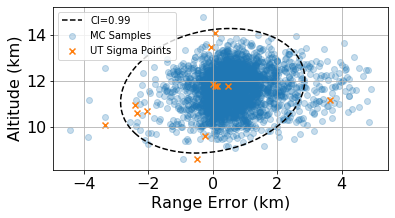

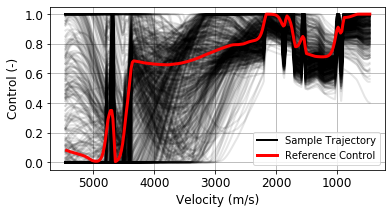

In [125]:
MCPlot(mc, interval=6, save=os.path.join(DIS_Images,'Trajectory'), suffix='Test')

In [5]:
def MonteCarloArray(mdir, mc_kwargs={}, plot=True):
    """ Runs Monte Carlos for a variety of solutions and plots the results in a variety of ways
    Designed for sweeps over the objective function weights 
    """
    # Old separate mat file format:
#     files = [fname for fname in list(os.walk(mdir))[0][2] if '.mat' in fname and not 'Matlab' in fname]
#     print(files)
#     dlist = [loadmat(os.path.join(mdir,fname)) for fname in list(os.walk(mdir))[0][2] if '.mat' in fname and not 'Matlab' in fname]

    # New way with sols in an array 
    dlist = mdir['sols']
    outputs = np.array([MonteCarlo(build_dict(data), **mc_kwargs)['output'] for data in dlist])
    
    w = np.squeeze([build_dict(data)['weights'] for data in dlist]).T
    try:
        alpha = np.squeeze([build_dict(data)['ut_scale_pair'] for data in dlist]).T
    except:
        alpha = []

    data = {'stats': outputs, 'weights': w, 'alpha': alpha}
    if plot:
        MCAPlots(data)
    
    return data
    
def collect(dics):
    """makes a new dictionary whose entries are full lists of the entries from a list of dicts"""
    dic = {}
    for key in dics[0].keys():
        dic[key] = [d[key] for d in dics]
    return dic 
    
def MCAPlots(results, figsize=(12,4), cmap='viridis', save=None, sweep='weights', prefix=''):    
    from matplotlib import gridspec
    # sweep is the variable(s) used to plot with. Choices so far are weights and alpha 
    outputs = results['stats']
    w = results[sweep]
    
    if save is not None:
        save_path = save
        save = True
    
    labels = {'weights': [r'$w_h$',r'$w_s$'], 'alpha': [r'$\alpha_{ref}$',r'$\alpha_{gain}$']}
    xlabel,ylabel = labels[sweep]
#     outputs = collect(outputs)
    
    best = np.argmin(outputs[:,3]) # lowest MC range error
    print("Lowest MC range error:")
    print(w.T[best])
    print(outputs[best]) # low alt, 3s range error 
    best = np.argmax(outputs[:,1]) # highest 3sigma low altitude MC
    print("Highest low altitude MC:")
    print(w.T[best])
    print(outputs[best]) # low alt, 3s range error 
    # Monte Carlo estimated results for different weights 
    N = 30
    hmin = min(np.min(outputs[:,0]), np.min(outputs[:,1]))
    hmax = max(np.max(outputs[:,0]), np.max(outputs[:,1]))
    print('Alt range: {}-{}'.format(hmin, hmax))
    smin = min(np.min(outputs[:,2]), np.min(outputs[:,3]))
    smax = max(np.max(outputs[:,2]), np.max(outputs[:,3]))
    print('S range: {}-{}'.format(smin, smax))
    
    hdraw = np.linspace(hmin, hmax, N)
    sdraw = np.linspace(smin, smax, N)

    fs = 12
    try:
# Monte Carlo Results
#         cmap = 'magma'
        plt.figure(figsize=figsize)

        plt.subplot(1, 2, 1)
        plt.tricontourf(w[0], w[1], outputs[:,1], N, cmap=cmap)
        plt.xlabel(xlabel, fontsize=fs)
        plt.ylabel(ylabel, fontsize=fs)
        cbar = plt.colorbar()
        cbar.set_label(r'3$\sigma$-Low Altitude (km)', fontsize=fs, labelpad=10)
        plt.gca().tick_params(axis='both', which='major', labelsize=fs-2)
        plt.axis('square')
        
        plt.subplot(1, 2, 2)
        plt.tricontourf(w[0], w[1], outputs[:,3], N, cmap=cmap+'_r')
        plt.xlabel(xlabel, fontsize=fs)
        plt.ylabel(ylabel, fontsize=fs)    
        cbar = plt.colorbar()
        cbar.set_label(r'3$\sigma$ Range Error (km)', fontsize=fs, labelpad=10)        
        plt.gca().tick_params(axis='both', which='major', labelsize=fs-2)
        plt.axis('square')
        if save:
#             plt.savefig(os.path.join(EDL_DIR,"Documents","PropellantOptimalJournal","ddp","python", "WeightSweepMC"), bbox_inches='tight', dpi=500)
            plt.savefig(os.path.join(save_path, prefix + "WeightSweepMCResults"), bbox_inches='tight', dpi=500)
        plt.figure(figsize=figsize)

        plt.subplot(1, 2, 1)
        plt.tricontourf(w[0], w[1], outputs[:,1], N, cmap=cmap)
        plt.xlabel(xlabel, fontsize=fs)
        plt.ylabel(ylabel, fontsize=fs)
        cbar = plt.colorbar()
        cbar.set_label(r'3$\sigma$-Low Altitude (km)', fontsize=fs, labelpad=10)
        plt.gca().tick_params(axis='both', which='major', labelsize=fs-2)
        plt.axis('square')
        
        plt.subplot(1, 2, 2)
        plt.tricontourf(w[0], w[1], outputs[:,3], N, cmap=cmap+'_r')
        plt.xlabel(xlabel, fontsize=fs)
        plt.ylabel(ylabel, fontsize=fs)    
        cbar = plt.colorbar()
        cbar.set_label(r'3$\sigma$ Range Error (km)', fontsize=fs, labelpad=10)        
        plt.gca().tick_params(axis='both', which='major', labelsize=fs-2)
        plt.axis('square')
        if save:
#             plt.savefig(os.path.join(EDL_DIR,"Documents","PropellantOptimalJournal","ddp","python", "WeightSweepMC"), bbox_inches='tight', dpi=500)
            plt.savefig(os.path.join(save_path, prefix + "WeightSweepMCMeanResults"), bbox_inches='tight', dpi=500)
    
        # Comparisons between UT and MC    
        f = plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.15]) 
        ax0 = plt.subplot(gs[0])
        plt.suptitle(r'3$\sigma$-Low Altitude (km)', fontsize=fs)
        ax0.tricontourf(w[0], w[1], outputs[:,0], hdraw)
        plt.xlabel(xlabel, fontsize=fs)
        plt.ylabel(ylabel, fontsize=fs) 
        plt.title('UT', fontsize=fs)
        
        ax1 = plt.subplot(gs[1])
        mappable = ax1.tricontourf(w[0], w[1], outputs[:,1], hdraw)
        plt.xlabel(xlabel, fontsize=fs)
        plt.ylabel(ylabel, fontsize=fs)    
        plt.title('MC', fontsize=fs)
        f.colorbar(mappable)
        
        if save:
            plt.savefig(os.path.join(save_path, prefix + "WeightSweepAltitudeCompare"), bbox_inches='tight', dpi=500)
            
        f = plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.15]) 
        ax0 = plt.subplot(gs[0])
        plt.suptitle('3$\sigma$ Range Errors (km)', fontsize=fs)
        plt.title('UT', fontsize=fs-2)
        plt.xlabel(xlabel, fontsize=fs)
        plt.ylabel(ylabel, fontsize=fs) 
        plt.tricontourf(w[0], w[1], outputs[:,2], sdraw)
        
        ax1 = plt.subplot(gs[1])
        plt.title('MC', fontsize=fs-2)
        mappable = ax1.tricontourf(w[0], w[1], outputs[:,3], sdraw)
        plt.xlabel(xlabel, fontsize=fs)
        plt.ylabel(ylabel, fontsize=fs) 
        plt.colorbar(mappable)
        if save:
            plt.savefig(os.path.join(save_path, prefix + "WeightSweepRangeCompare"), bbox_inches='tight', dpi=500)
            
        # TODO: show error plots between DDP and MC in asbolute units and maybe also as a percent difference?
        plt.figure(figsize=figsize)
        plt.suptitle('UT - MC (positive indicates an overestimate)', fontsize=fs)
        plt.subplot(1, 2, 1)
        plt.title(r'$3\sigma$-Low Altitude UT Estimation Error (km)', fontsize=fs-2)
        plt.tricontourf(w[0], w[1], (outputs[:,0]-outputs[:,1]))
        plt.colorbar()
        plt.tricontour(w[0], w[1], (outputs[:,0]-outputs[:,1]), [0])
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)

        plt.subplot(1, 2, 2)
        plt.title(r'3$\sigma$ Range Error UT Estimation Error (km)', fontsize=fs-2)
        plt.tricontourf(w[0], w[1], (outputs[:,2]-outputs[:,3]))
        plt.colorbar()    
        plt.tricontour(w[0], w[1], (outputs[:,2]-outputs[:,3]), [0]) # show the divide between over and under predictions 
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)
        if save:
            plt.savefig(os.path.join(save_path, prefix + "WeightSweepError"), bbox_inches='tight', dpi=500)
            
        # Percent errors 
        plt.figure(figsize=figsize)
        plt.suptitle('UT - MC (positive indicates an overestimate)', fontsize=fs)
        plt.subplot(1, 2, 1)
        plt.title(r'$3\sigma$-Low Altitude UT Estimation Error (%)', fontsize=fs-2)
        plt.tricontourf(w[0], w[1], 100*(outputs[:,0]-outputs[:,1])/outputs[:,1])            
        plt.colorbar()
        plt.tricontour(w[0], w[1], 100*(outputs[:,0]-outputs[:,1])/outputs[:,1],[0])
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)

        plt.subplot(1, 2, 2)
        plt.title(r'3$\sigma$ Range Error UT Estimation Error (%)', fontsize=fs-2)
        plt.tricontourf(w[0], w[1], 100*(outputs[:,2]-outputs[:,3])/outputs[:,3])
        plt.colorbar()    
        plt.tricontour(w[0], w[1], 100*(outputs[:,2]-outputs[:,3])/outputs[:,3], [0]) # show the divide between over and under predictions 
        plt.xlabel(r'$w_h$', fontsize=fs)
        plt.ylabel(r'$w_s$', fontsize=fs)
        if save:
            plt.savefig(os.path.join(save_path, prefix + "WeightSweepAltitudePercentError"), bbox_inches='tight', dpi=500)
            
        # Altitude vs Range Error
    #     plt.figure(figsize=(14, 6))
    #     plt.suptitle('Trade Off', fontsize=fs)
    #     plt.subplot(1, 2, 1)
    #     plt.title('DDP', fontsize=fs)
    #     plt.scatter(outputs[:,1,0], outputs[:,0,0])
    #     plt.xlabel('3sigma Range Error (km)')
    #     plt.ylabel('3sigma Low Altitude (km)')

    #     plt.subplot(1, 2, 2)
    #     plt.title('MC')
    #     plt.scatter(outputs[:,1,1], outputs[:,0,1])
    #     plt.xlabel('3sigma Range Error (km)')
    #     plt.ylabel('3sigma Low Altitude (km)')    
    except Exception as e:
        print(e)
plt.show()


In [ ]:
sols = [build_dict(sol) for sol in data['sols']]
w = np.vstack([sol['weights'] for sol in sols])
print(w)

In [ ]:
sols[0]['input']['gains']

In [ ]:
print(w[0],w[12],w[3])
fs = 16
colors = ['b','r','y']
j = 0
plt.figure(figsize=(8,6))
for i in [0,12,3]:
    sol = sols[i]
    u = smooth.smooth(sol['v'][1:][::-1],sol['u'][::-1], 3, 50)(sol['v'][1:])
#     u = sol['u']
    plt.plot(sol['v'][1:], u, label=r'$w_h={:n}, w_s={:n}$'.format(*sol['weights'][:-1]), linewidth=4, c=colors[j])
    j += 1

plt.xlabel('Velocity (m/s)', fontsize=fs)
plt.ylabel(r'$\cos\sigma$ (-)', fontsize=fs)
plt.gca().tick_params(axis='both', which='major', labelsize=16)
plt.grid(1)
plt.legend()
plt.savefig(r'C:\Users\cdnoyes\Documents\EDL\Documents\PropellantOptimalJournal\ddp\matlab\RobustControl.png', bbox_inches='tight')
plt.show()

In [43]:
sol = MonteCarlo(build_dict(data['sols'][3]), 10, debug=False, parametric=True)

[3.  0.  0.2]
 
Generating 10 samples...
 
Generating 10 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [  0.714  -0.212 -64.97 ]
Something wrong
(10, 5)
Mean Altitude
	DDP: 4.663 km
	MC:  4.592 km
3-sigma Low Altitude
	DDP: 1.972 km
	MC:  2.212 km
3-sigma DR
	DDP: 4.975 km
	MC:  4.601 km


<ipython-input-30-878193b3a72a>:7: RuntimeWarning: overflow encountered in cosh
  return 0.5 + 0.25/tuning*np.log(np.cosh(tuning*(q+1))/np.cosh(tuning*(q-1)))


In [11]:


# data = loadmat(os.path.join(DOC,'GitHub\\Research\\Matlab\\iLQR','overcontrol_test.mat'), squeeze_me=True)
# data = loadmat(os.path.join(DOC,'GitHub\\Research\\Matlab\\','LDtest.mat'), squeeze_me=True)

# data = loadmat(os.path.join(DOC,'GitHub\\Research\\Matlab\\','UTScale.mat'), squeeze_me=True)

# files:
# margin_comparison = six cases each with the nominal fixed gains
# reference_comparison_fixed_gains.mat = same six cases but with gains optimized for the 6th trajectory to minimize range errors
# reference_comparison_opt_gains.mat = same six cases but with different fixed gains optimized for each trajectory 

# weight sweep files:
# 'solutions_cl_ddp_max.mat'       # using previous solution as guess 
# 'solutions_cl_ddp_max_guess.mat' # all with same nominal guess
# 'solutions_cl_ddp_optimized.mat' # reoptimized gains for each sol

# data = data_loader('margin_comparison')

In [14]:
data = data_loader('margin_comparison_0p24')
stats = MonteCarloArray(data, {'N': 8000, 'parametric': True, 'sample': 'L'}, plot=False)


Weights: [0 0 0]
Downrange Target = 265.583 km
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.072 -0.025 -4.   ]
1% altitude = 8.076 km
99% range error = 16.940 km
Nominal opt, setting DDP mean/var to zeros
Mean range error = -4.34 km
Mean Altitude
	DDP: 0.000 km
	MC:  11.056 km
3-sigma Low Altitude
	DDP: 0.000 km
	MC:  8.051 km
3-sigma DR Error
	DDP: 0.000 km
	MC:  15.718 km

Weights: [0 0 0]
Downrange Target = 274.265 km
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.072 -0.025 -4.   ]
1% altitude = 8.573 km
99% range error = 13.324 km
Nominal opt, setting DDP mean/var to zeros
Mean range error = -2.31 km
Mean Altitude
	DDP: 0.000 km
	MC:  10.983 km
3-sigma Low Altitude
	DDP: 0.000 km
	MC:  8.374 km
3-sigma DR Error
	DDP: 0.000 km
	MC:  13.103 km

Weights: [0 0 0]
Downrange Target = 288.4

## Fixed gain for improved case 6

In [13]:
data = data_loader('reference_comparison_fixed_gains.mat')
stats = MonteCarloArray(data, {'N': 8000, 'parametric': True, 'sample': 'L'}, plot=False)


Weights: [0 0 0]
Downrange Target = 296.347 km
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.07  -0.024 -5.225]
Nominal opt, setting DDP mean/var to zeros
Mean range error = -3.3 km
Mean Altitude
	DDP: 0.000 km
	MC:  6.440 km
3-sigma Low Altitude
	DDP: 0.000 km
	MC:  3.102 km
3-sigma DR Error
	DDP: 0.000 km
	MC:  21.670 km

Weights: [0 0 0]
Downrange Target = 312.646 km
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.07  -0.024 -5.225]
Nominal opt, setting DDP mean/var to zeros
Mean range error = -1.6 km
Mean Altitude
	DDP: 0.000 km
	MC:  6.207 km
3-sigma Low Altitude
	DDP: 0.000 km
	MC:  3.544 km
3-sigma DR Error
	DDP: 0.000 km
	MC:  16.008 km

Weights: [0 0 0]
Downrange Target = 345.987 km
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric

## Gains reoptimized for each of the 6 cases

In [14]:
data = data_loader('reference_comparison_opt_gains.mat')
stats = MonteCarloArray(data, {'N': 8000, 'parametric': True, 'sample': 'L'}, plot=False)


Weights: [0.   0.01 0.  ]
Downrange Target = 297.282 km
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [0.023 0.    2.653]
Mean range error = 0.4 km
Mean Altitude
	DDP: 7.141 km
	MC:  6.846 km
3-sigma Low Altitude
	DDP: 4.546 km
	MC:  4.565 km
3-sigma DR Error
	DDP: 54.551 km
	MC:  55.125 km

Weights: [0.   0.01 0.  ]
Downrange Target = 311.816 km
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.027 -0.001  3.072]
Mean range error = -0.3 km
Mean Altitude
	DDP: 6.583 km
	MC:  6.355 km
3-sigma Low Altitude
	DDP: 4.231 km
	MC:  4.182 km
3-sigma DR Error
	DDP: 38.498 km
	MC:  38.217 km

Weights: [0.   0.01 0.  ]
Downrange Target = 345.146 km
 
Generating 8000 samples...
 
Generating 8000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.048 -0.015  1.7

## Weight Sweep - Open Loop Scenario

In [7]:
data = data_loader('msl_weight_sweep_open_loop.mat')
open_stats = MonteCarloArray(data, {'N': 3000, 'parametric': True, 'sample': 'L'}, plot=False)


Weights: [0.  0.  0.1]
Downrange Target = 261.409 km
 
Generating 3000 samples...
 
Generating 3000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [0 0 0]
MSL vehicle with specified L/D
1% altitude = 11.181 km
99% range error = 57.113 km
Mean range error = 0.62 km
Mean Altitude
	DDP: 13.441 km
	MC:  13.232 km
3-sigma Low Altitude
	DDP: 10.597 km
	MC:  10.704 km
3-sigma DR Error
	DDP: 66.636 km
	MC:  65.047 km

Weights: [1.  0.  0.1]
Downrange Target = 261.349 km
 
Generating 3000 samples...
 
Generating 3000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [0 0 0]
MSL vehicle with specified L/D
1% altitude = 11.171 km
99% range error = 57.193 km
Mean range error = 0.67 km
Mean Altitude
	DDP: 13.427 km
	MC:  13.220 km
3-sigma Low Altitude
	DDP: 10.618 km
	MC:  10.694 km
3-sigma DR Error
	DDP: 66.451 km
	MC:  66.210 km

Weights: [2.  0.  0.1]
Downrange Target = 261.166 km
 
Generating 3000 samp

Lowest MC range error:
[1.  3.  0.1]
[ 7.768  7.933 59.913 59.092]
Highest low altitude MC:
[0.  0.  0.1]
[10.597 10.701 66.636 65.894]
Alt range: 7.730465083998741-10.701475247227352
S range: 59.09192129740714-66.63560089526621


<ipython-input-66-1d104a09ca28>:155: UserWarning: No contour levels were found within the data range.
  plt.tricontour(w[0], w[1], (outputs[:,0]-outputs[:,1]), [0])
<ipython-input-66-1d104a09ca28>:176: UserWarning: No contour levels were found within the data range.
  plt.tricontour(w[0], w[1], 100*(outputs[:,0]-outputs[:,1])/outputs[:,1],[0])


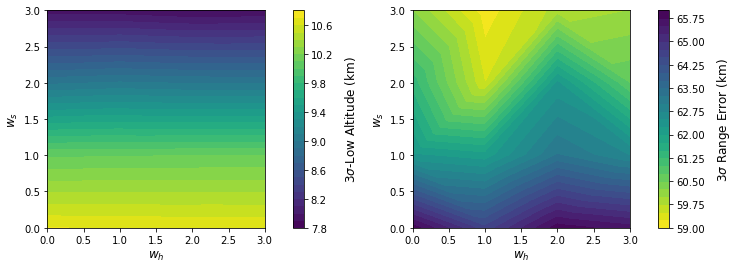

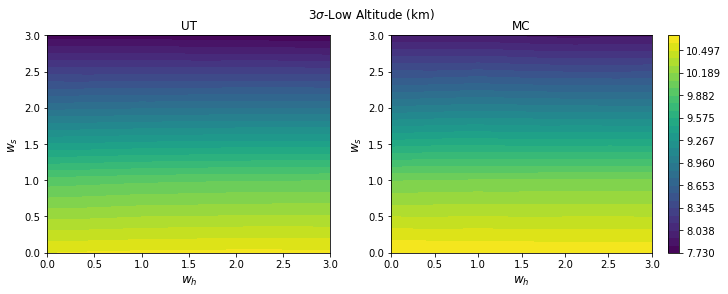

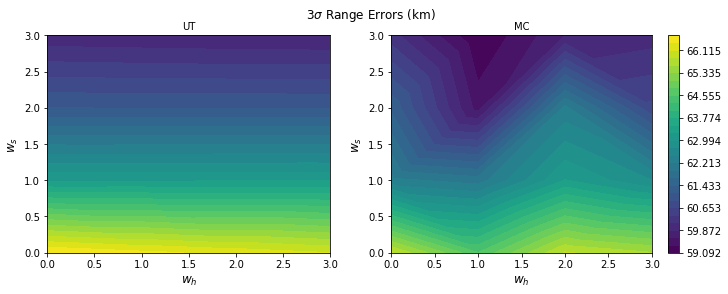

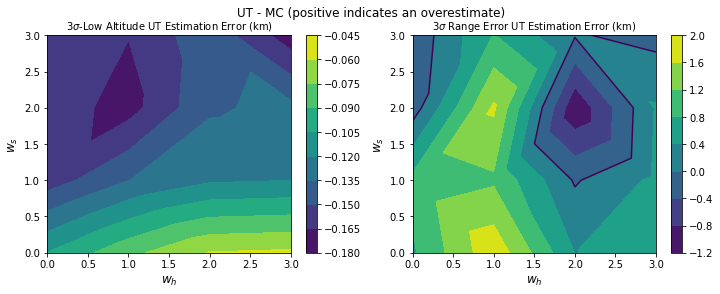

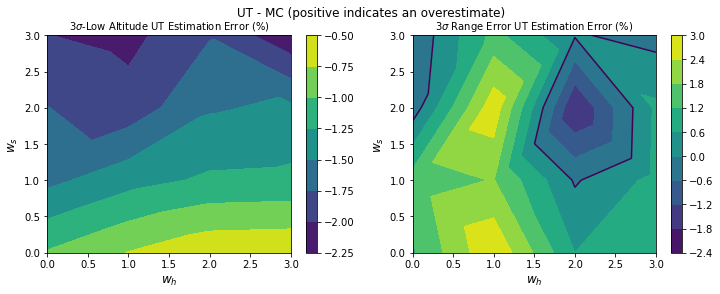

In [77]:
MCAPlots(open_stats, save=DIS_Images, prefix='OpenLoop_')

## Weight Sweep - Fixed Gain Scenario

In [10]:
data = data_loader('solutions_cl_ddp_max_guess.mat') # heavy vehicle used in paper results 
heavy_stats = MonteCarloArray(data, {'N': 3000, 'parametric': True, 'sample': 'L'}, plot=False)


Weights: [0.  0.  0.2]
Downrange Target = 302.559 km
No mass/aero data in input, using 5000 kg
 
Generating 3000 samples...
 
Generating 3000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.072 -0.025 -4.   ]
Heavy vehicle with constant aero, L/D=0.2901863715783343
1% altitude = 3.134 km
99% range error = 15.190 km
Mean range error = -1.28 km
Mean Altitude
	DDP: 6.588 km
	MC:  6.324 km
3-sigma Low Altitude
	DDP: 2.625 km
	MC:  3.285 km
3-sigma DR Error
	DDP: 17.675 km
	MC:  15.387 km

Weights: [1.  0.  0.2]
Downrange Target = 313.764 km
No mass/aero data in input, using 5000 kg
 
Generating 3000 samples...
 
Generating 3000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.072 -0.025 -4.   ]
Heavy vehicle with constant aero, L/D=0.2901863715783343
1% altitude = 3.981 km
99% range error = 14.303 km
Mean range error = -1.15 km
Mean Altitude
	DDP: 6.510 km
	MC:  6.283 km
3-sigma Low Altitu

Lowest MC range error:
[1.  3.  0.2]
[2.456 2.597 1.411 2.23 ]
Highest low altitude MC:
[2.  0.  0.2]
[ 3.233  3.744 12.836 12.962]
Alt range: 2.4558054843235033-3.7437007648410643
S range: 1.4109352347256936-17.67549243500911


E:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:161: UserWarning: No contour levels were found within the data range.
E:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:182: UserWarning: No contour levels were found within the data range.


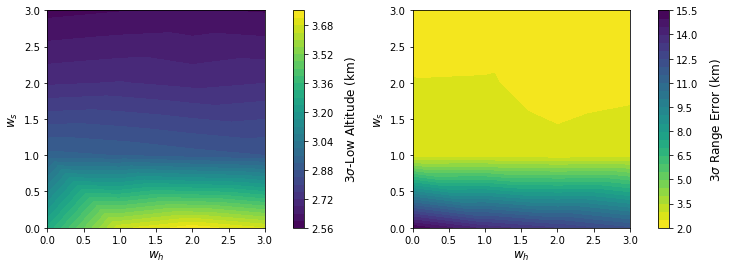

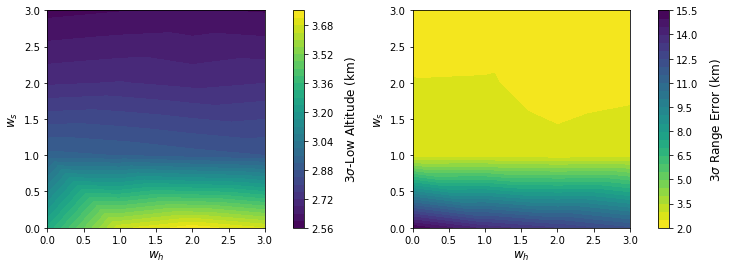

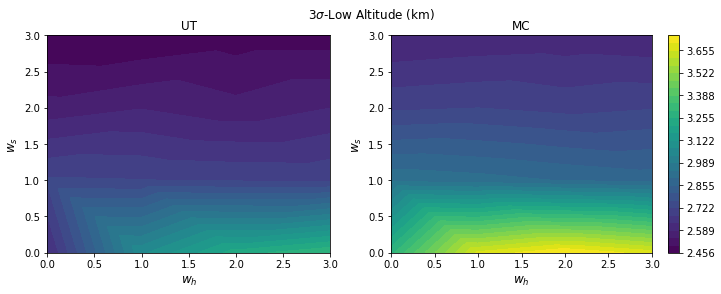

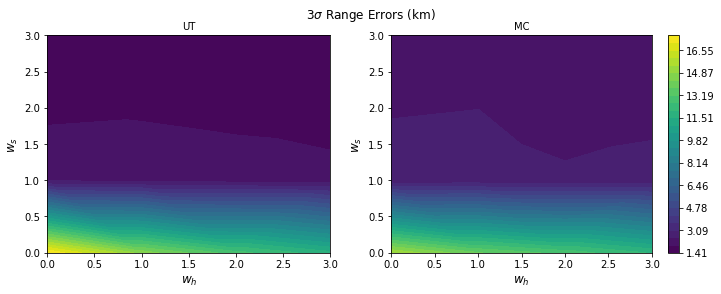

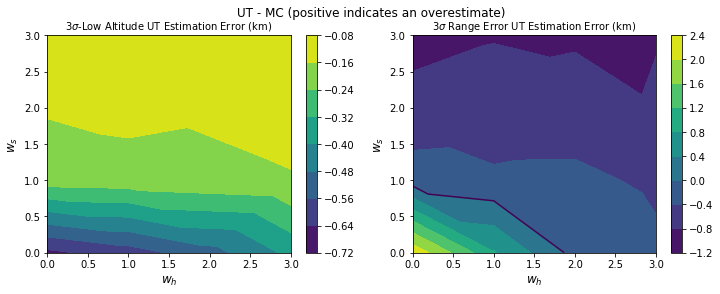

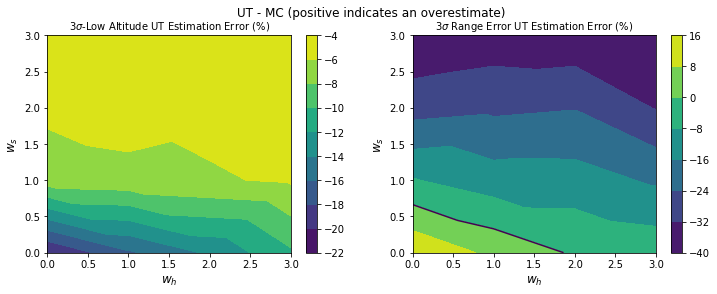

In [13]:
MCAPlots(heavy_stats, save=Paper_Images, prefix='Heavy_')

### MSL CLass

In [8]:
# data = data_loader('solutions_cl_ddp_max_guess.mat') # heavy vehicle used in paper results 
data = data_loader('msl_weight_sweep.mat')
msl_stats = MonteCarloArray(data, {'N': 3000, 'parametric': True, 'sample': 'L'}, plot=False)
# MCAPlots(msl_stats)


Weights: [0.  0.  0.1]
Downrange Target = 270.457 km
 
Generating 3000 samples...
 
Generating 3000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.131 -0.039 -2.521]
MSL vehicle with specified L/D
1% altitude = 9.484 km
99% range error = 20.150 km
Mean range error = -1.21 km
Mean Altitude
	DDP: 12.734 km
	MC:  12.475 km
3-sigma Low Altitude
	DDP: 8.457 km
	MC:  9.219 km
3-sigma DR Error
	DDP: 12.778 km
	MC:  17.440 km

Weights: [1.  0.  0.1]
Downrange Target = 279.001 km
 
Generating 3000 samples...
 
Generating 3000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.131 -0.039 -2.521]
MSL vehicle with specified L/D
1% altitude = 9.842 km
99% range error = 20.181 km
Mean range error = -1.36 km
Mean Altitude
	DDP: 12.713 km
	MC:  12.548 km
3-sigma Low Altitude
	DDP: 9.071 km
	MC:  9.706 km
3-sigma DR Error
	DDP: 10.866 km
	MC:  16.537 km

Weights: [2.  0.  0.1]
Downrange Target = 287.782

Lowest MC range error:
[0.  3.  0.1]
[8.611 9.213 4.258 6.503]
Highest low altitude MC:
[2.  0.  0.1]
[ 9.516  9.75  10.608 15.517]
Alt range: 8.456717577980164-9.749811751034411
S range: 4.217359796258849-17.221112457718952


<ipython-input-66-1d104a09ca28>:155: UserWarning: No contour levels were found within the data range.
  plt.tricontour(w[0], w[1], (outputs[:,0]-outputs[:,1]), [0])
<ipython-input-66-1d104a09ca28>:163: UserWarning: No contour levels were found within the data range.
  plt.tricontour(w[0], w[1], (outputs[:,2]-outputs[:,3]), [0]) # show the divide between over and under predictions
<ipython-input-66-1d104a09ca28>:176: UserWarning: No contour levels were found within the data range.
  plt.tricontour(w[0], w[1], 100*(outputs[:,0]-outputs[:,1])/outputs[:,1],[0])
<ipython-input-66-1d104a09ca28>:184: UserWarning: No contour levels were found within the data range.
  plt.tricontour(w[0], w[1], 100*(outputs[:,2]-outputs[:,3])/outputs[:,3], [0]) # show the divide between over and under predictions


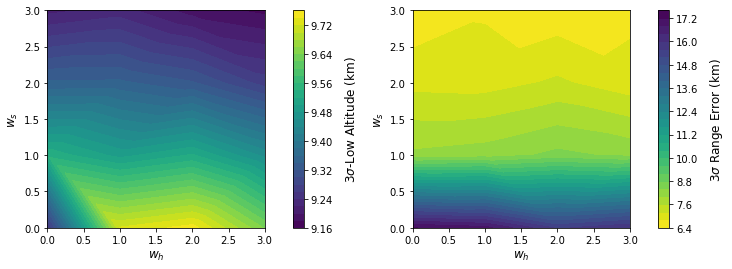

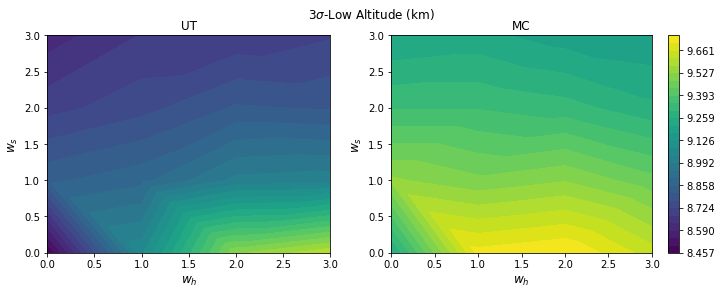

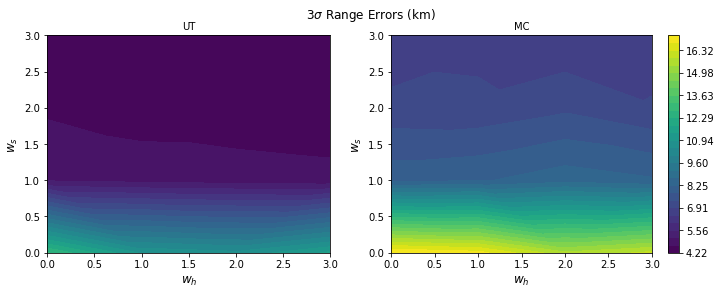

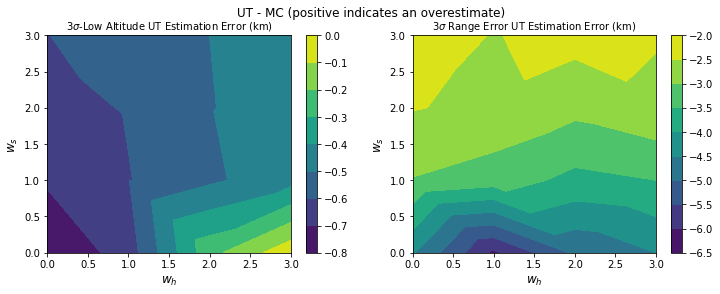

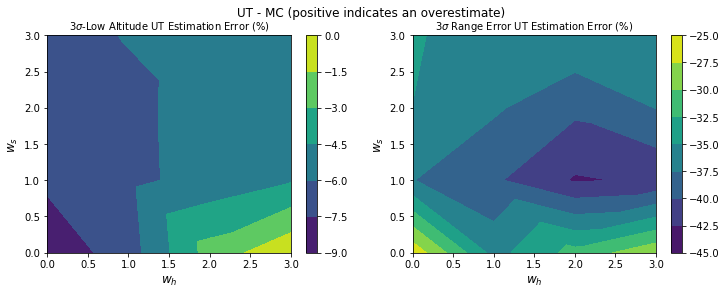

In [68]:
MCAPlots(msl_stats, save=DIS_Images, prefix='MSL_')

In [9]:
data = data_loader('msl_weight_sweep_reestimated.mat')
est_stats = MonteCarloArray(data, {'N': 3000, 'parametric': True, 'sample': 'L'}, plot=False)
# MCAPlots(est_stats)

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Documents\\GitHub\\Research\\Matlab\\msl_weight_sweep_reestimated.mat'

Lowest MC range error:
[1.  3.  0.1]
[8.969 9.097 4.492 5.663]
Highest low altitude MC:
[1.  0.  0.1]
[ 9.482  9.681 12.155 14.637]
Alt range: 8.910348471677285-9.68051157389792
S range: 4.441797603786027-15.637731537515734


<ipython-input-66-1d104a09ca28>:163: UserWarning: No contour levels were found within the data range.
  plt.tricontour(w[0], w[1], (outputs[:,2]-outputs[:,3]), [0]) # show the divide between over and under predictions
<ipython-input-66-1d104a09ca28>:184: UserWarning: No contour levels were found within the data range.
  plt.tricontour(w[0], w[1], 100*(outputs[:,2]-outputs[:,3])/outputs[:,3], [0]) # show the divide between over and under predictions


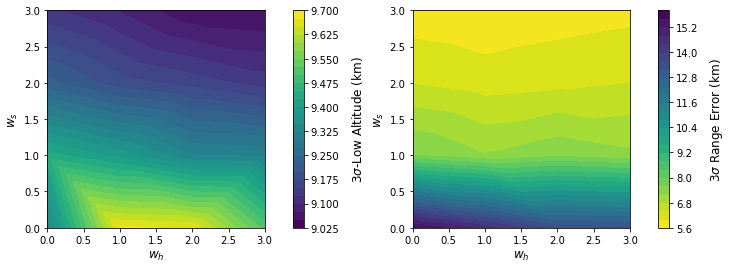

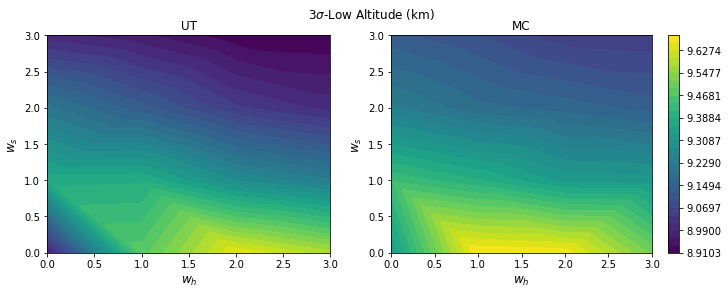

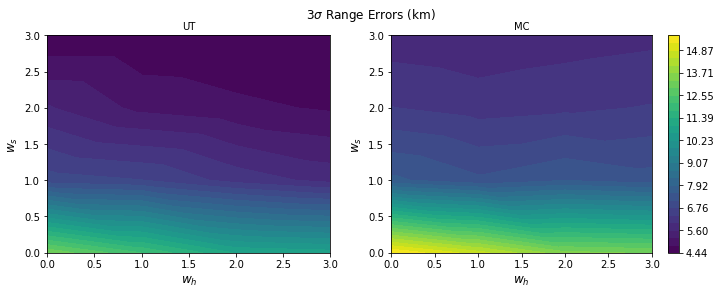

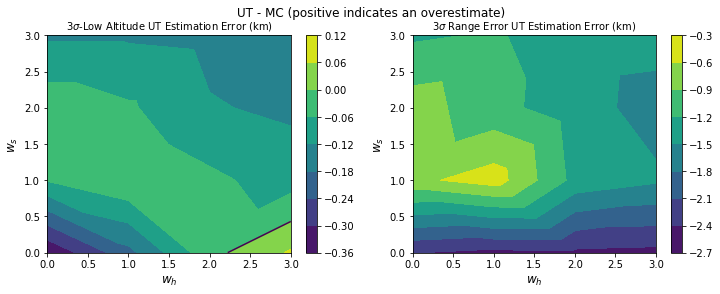

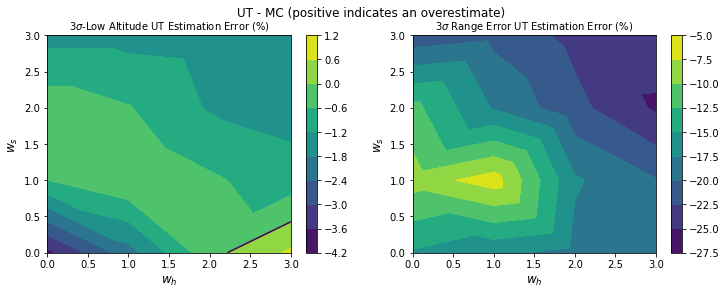

In [70]:
MCAPlots(est_stats, save=DIS_Images, prefix='Reestimated_')

## Weight Sweep with Reoptimized Gains 

In [ ]:
# data = data_loader('solutions_cl_ddp_optimized.mat')
data = data_loader('msl_weight_sweep_optimized.mat')
opt_stats = MonteCarloArray(data, {'N': 3000, 'parametric': True, 'sample': 'L'}, plot=False)
MCAPlots(opt_stats)

Lowest MC range error:
[0.  2.  0.1]
[9.129 9.271 3.163 3.057]
Highest low altitude MC:
[1.  0.  0.1]
[10.601 10.591 45.942 45.375]
Alt range: 8.870764371905858-10.60080709370658
S range: 2.8121923821012764-48.79598578187497


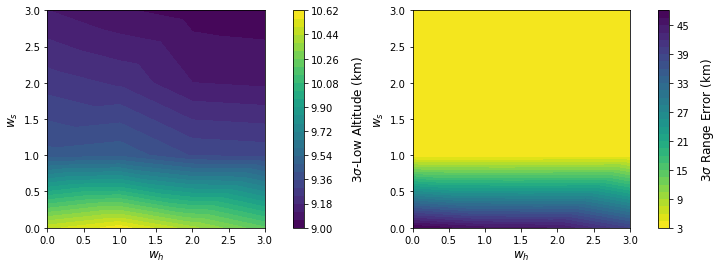

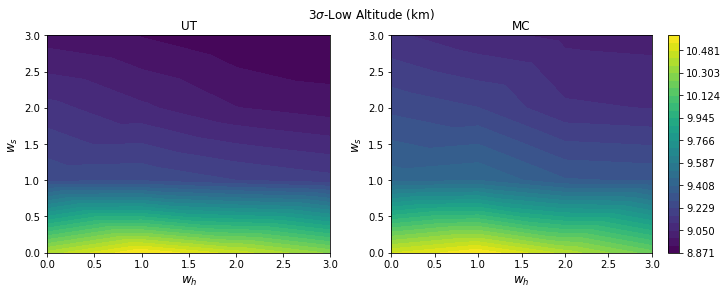

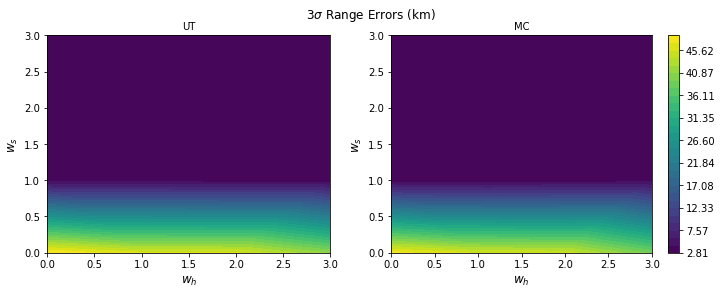

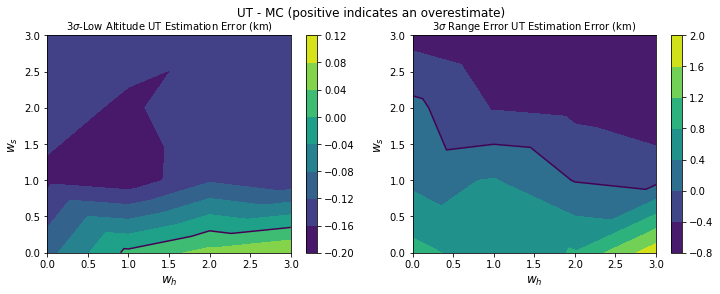

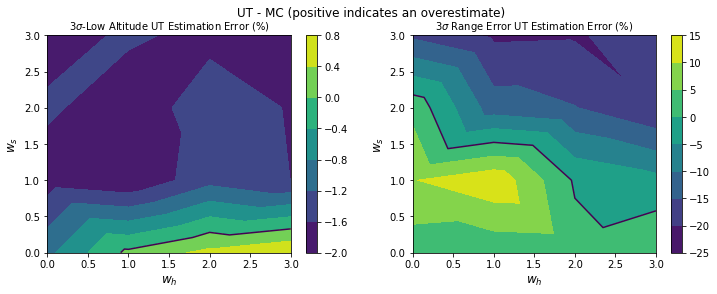

In [72]:
MCAPlots(opt_stats, save=DIS_Images, prefix='Reoptimized_')

## Dual Alpha Sweep - Different UT Scaling for Ref opt and Gain opt
Results: not very good - best case range error inferior to static gains (1.8 vs 2 km). Seems a bit like overfitting 

In [33]:
data = data_loader('alpha_sweep\\alpha_sweep.mat')
stats = MonteCarloArray(data, {'N': 3000, 'parametric': True, 'sample': 'L'}, plot=False)


Weights: [1.  1.  0.3]
Downrange Target = 327.584 km
 
Generating 3000 samples...


<ipython-input-27-19385081af2c>:7: RuntimeWarning: overflow encountered in cosh
  q = 0.5 + 0.25/tuning*np.log(np.cosh(tuning*(q+1))/np.cosh(tuning*(q-1)))
<ipython-input-27-19385081af2c>:7: RuntimeWarning: invalid value encountered in true_divide
  q = 0.5 + 0.25/tuning*np.log(np.cosh(tuning*(q+1))/np.cosh(tuning*(q-1)))
<ipython-input-27-19385081af2c>:7: RuntimeWarning: divide by zero encountered in log
  q = 0.5 + 0.25/tuning*np.log(np.cosh(tuning*(q+1))/np.cosh(tuning*(q-1)))


1% altitude = 0.161 km
99% range error = 9.791 km
Mean range error = -0.55 km
Mean Altitude
	DDP: 5.512 km
	MC:  5.431 km
3-sigma Low Altitude
	DDP: 3.428 km
	MC:  2.381 km
3-sigma DR Error
	DDP: 0.537 km
	MC:  10.409 km

Weights: [1.  1.  0.3]
Downrange Target = 330.210 km
 
Generating 3000 samples...
1% altitude = 4.298 km
99% range error = 4.737 km
Mean range error = -0.53 km
Mean Altitude
	DDP: 5.513 km
	MC:  5.639 km
3-sigma Low Altitude
	DDP: 3.307 km
	MC:  4.714 km
3-sigma DR Error
	DDP: 0.651 km
	MC:  4.606 km

Weights: [1.  1.  0.3]
Downrange Target = 333.365 km
 
Generating 3000 samples...
1% altitude = 4.677 km
99% range error = 3.243 km
Mean range error = -0.27 km
Mean Altitude
	DDP: 5.446 km
	MC:  5.587 km
3-sigma Low Altitude
	DDP: 3.206 km
	MC:  4.972 km
3-sigma DR Error
	DDP: 0.653 km
	MC:  3.203 km

Weights: [1.  1.  0.3]
Downrange Target = 334.146 km
 
Generating 3000 samples...
1% altitude = 4.208 km
99% range error = 5.568 km
Mean range error = -0.45 km
Mean Altitud

Lowest MC range error:
[ 5 11]
[3.402 3.737 0.361 2.006]
Highest low altitude MC:
[ 9 17]
[2.881 4.994 0.542 2.476]
Alt range: -5.774090730122596-4.993930314302631
S range: 0.20675618315893615-198.81702487226335


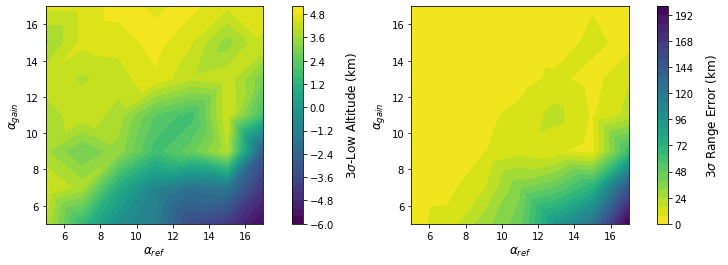

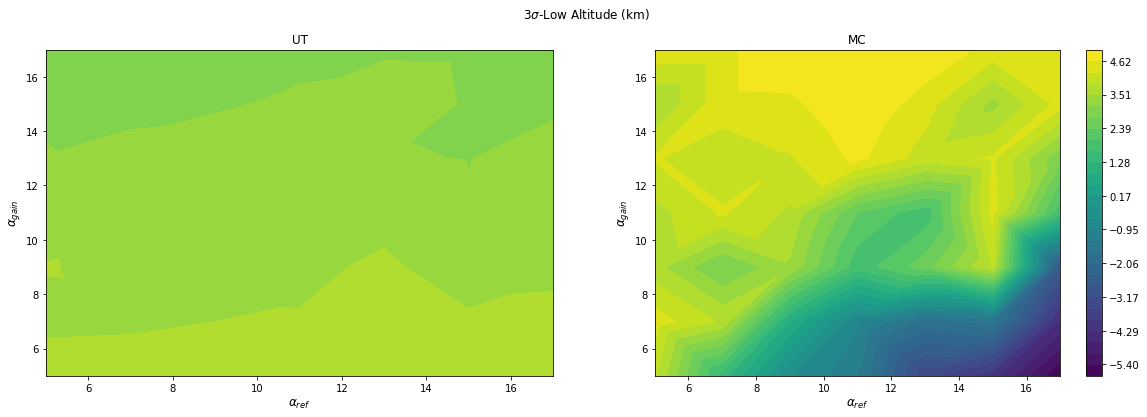

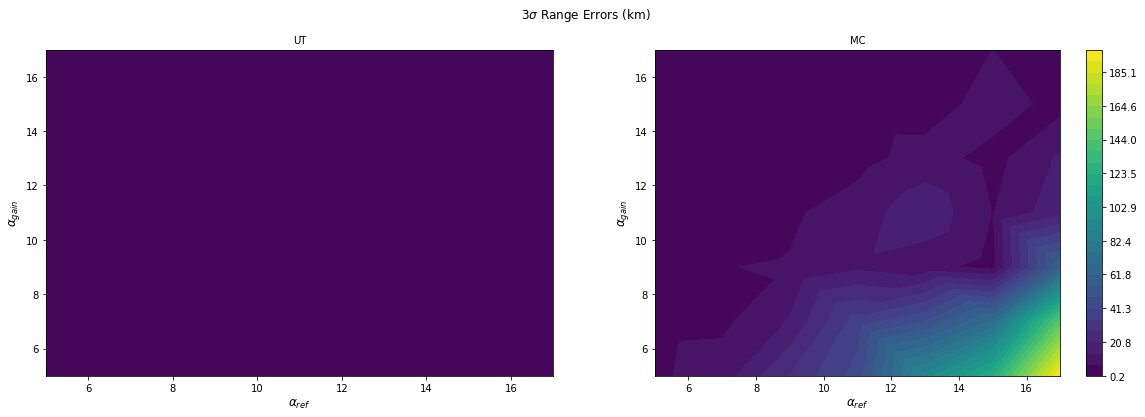

In [34]:
stats['alpha'].shape
stats['stats'].shape
MCAPlots(stats, sweep='alpha')

## Overcontrol Gain, single Alpha sweep

In [37]:
data = data_loader('alpha_sweep\\cov_overcontrol_sols.mat')
stats = MonteCarloArray(data, {'N': 3000, 'parametric': True, 'sample': 'L'}, plot=False)


Weights: [1.  1.  0.3]
Downrange Target = 354.504 km
 
Generating 3000 samples...
 
Generating 3000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain + Overcontrol
1% altitude = 3.061 km
99% range error = 6.941 km
Mean range error = -0.46 km
Mean Altitude
	DDP: 4.818 km
	MC:  5.012 km
3-sigma Low Altitude
	DDP: 1.322 km
	MC:  2.620 km
3-sigma DR Error
	DDP: 1.315 km
	MC:  6.442 km

Weights: [1.  1.  0.3]
Downrange Target = 354.523 km
 
Generating 3000 samples...
 
Generating 3000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain + Overcontrol
1% altitude = 2.995 km
99% range error = 4.103 km
Mean range error = -0.16 km
Mean Altitude
	DDP: 4.698 km
	MC:  4.843 km
3-sigma Low Altitude
	DDP: 1.190 km
	MC:  2.460 km
3-sigma DR Error
	DDP: 2.315 km
	MC:  5.837 km

Weights: [1.  1.  0.3]
Downrange Target = 355.676 km
 
Generating 3000 samples...
 
Generating 3000 samples...
     Sobol sampling method
     Parametric uncertainty

KeyError: 'ut_scale_pair'

In [98]:
pydata = build_dict(data['sols'][-1])

In [99]:
sol = MonteCarlo(pydata, 2000, debug=False, parametric=True)

[3.  1.  0.2]
 
Generating 2000 samples...
 
Generating 2000 samples...
     Sobol sampling method
     Parametric uncertainty only
Mean Altitude
	DDP: 5.348 km
	MC:  5.231 km
3-sigma Low Altitude
	DDP: 3.021 km
	MC:  3.056 km
3-sigma DR
	DDP: 0.029 km
	MC:  3.075 km


699 cases (34.95%) are non-behavioral.

Input   KS      P
--------------------
CD     0.29   0.000
CL     0.28   0.000
h0     0.20   0.000
fpa0   0.11   0.000
s0     0.08   0.008




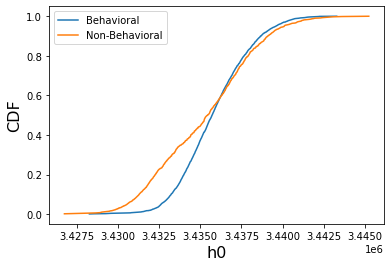

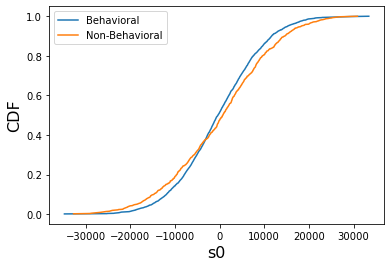

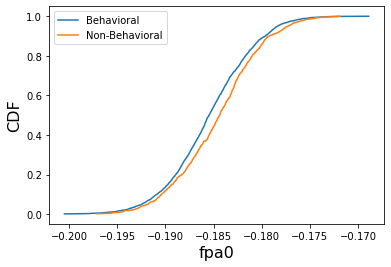

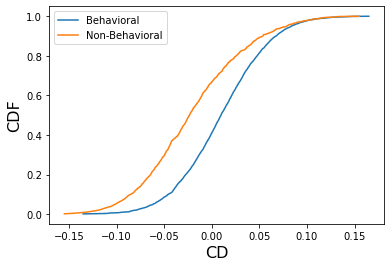

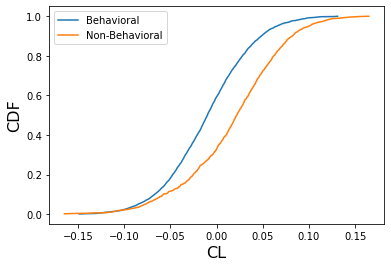

In [106]:
mc = sol['mc']
x0 = mc.mc_full['state'][0][:-1]
p0 = mc.samples
# print(x0.shape, p0.shape)
X0 = np.vstack([x0,p0])
# print(X0.shape)
MCAnalyze(X0[:-1], mc.xf)

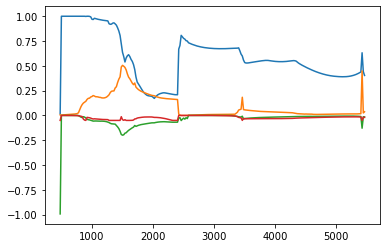

In [96]:
plt.plot(pydata['v'][:-1],pydata['u'].T)

# Single MC Analysis
Individualized plots, etc.

In [ ]:
# data = loadmat(os.path.join("E:\\Documents\\GitHub\\Research\\Matlab",'Beta5.mat'))
# data = loadmat(os.path.join('E:\\Documents\\GitHub\\Research\\Matlab\\iLQR\\solutions\\beta_sweep','Beta16.mat'))
# data = loadmat(os.path.join('E:\\Documents\\GitHub\\Research\\Matlab\\iLQR\\solutions\\fixed_gain','Sol22.mat'))
data = loadmat(os.path.join('E:\\Documents\\GitHub\\Research\\Matlab\\iLQR\\solutions\\margin','Sol2.mat'))


sol = MonteCarlo(data, 3000, debug=False, parametric=True)

In [ ]:
mc = sol['mc']
mc.mc_full['state'][0].shape
X = mc.mc_full['state']
xf = mc.xf

fun = np.log
for x in np.transpose(X, (2,1,0)):
    k = x[2] >= 480
    
    plt.figure(1, figsize=(10,10))
    plt.loglog(x[2,k], fun(x[0,k]/1000-3396.2), 'c', alpha=0.25)
    plt.grid(True)
    
    plt.figure(2, figsize=(10,10))
    plt.plot(x[2,k], x[1,k]/1000)
    

plt.figure(1, figsize=(10,10))
plt.loglog(data['v'], fun(data['h'].T/1000), 'k')    
plt.grid(True)
if 0:
    plt.axis([475, 720, 4.5, 17]) # end
    
plt.figure(2, figsize=(10,10))
plt.plot(data['v'], data['s'].T, 'k')
plt.grid(True)
if 0:
    plt.axis([450, 520, 410, 450]) # end
#     plt.axis([5300, 5550, -100, 100]) # start

plt.show()

In [ ]:
plt.figure(3, figsize=(10,10))
c = np.sin(mc.mc_full['state'][0][3]) #*mc.mc_full['state'][0][1]
plt.scatter(xf.T[1]/1000, xf.T[0]/1000-3396.2, c=c)
plt.colorbar()

plt.figure(4, figsize=(10,10))
c = np.sin(mc.mc_full['state'][0][3])*np.abs(mc.mc_full['state'][0][1])
plt.scatter(mc.mc_full['state'][0][1], np.degrees(mc.mc_full['state'][0][3]), c=xf.T[1]/1000-np.mean(xf.T[1]/1000))
plt.colorbar()

In [ ]:
mc.mc_full['state'][0].shape

In [ ]:
mc = sol['mc']
x0 = mc.mc_full['state'][0][:-1]
MCAnalyze(x0, mc.xf)

# Multiple MC Analysis

In [ ]:
data = loadmat(os.path.join('C:\\Users\cdnoyes\\Documents\\GitHub\\Research\\Matlab\\','solutions_cl_ddp_max.mat'), squeeze_me=True)


In [ ]:
out = MonteCarloArray('E:\\Documents\\GitHub\\Research\\Matlab\iLQR\solutions\\margin', {'N': 3000,'parametric': True})

In [ ]:
# out = MonteCarloArray('E:\\Documents\\GitHub\\Research\\Matlab\\iLQR\\solutions\\beta_sweep')
out = MonteCarloArray('E:\\Documents\\GitHub\\Research\\Matlab\iLQR\solutions\\all_unc')

In [ ]:
plt.figure()
plt.plot(np.linspace(0,0.75,10), out[:,1,0]*1000)
plt.plot(np.linspace(0,0.75,10), out[:,1,1:])
plt.figure()
plt.plot(np.linspace(0,0.75,10), out[:,0,:])
plt.show()

In [ ]:
mdir = "E:\Documents\GitHub\Research\Matlab"
fname = 'Beta8.mat'
# mdir = 'E:\\Documents\\GitHub\\Research\\Matlab\iLQR\solutions\\' 
# fname = "Robust31.mat"  # numbers indicate weights wh and ws
# fname = "FixedGainTestSolution.mat"

data = loadmat(os.path.join(mdir,fname))

In [ ]:
P0 = data['input'][0][0][2]
N = 2000
x0 = data['mean'].T[0]
X0 = cp.MvNormal(x0, P0).sample(N, 'L')

# X0, mw, cw = Unscented.Transform(x0, P0, k=4)
# X0 = X0.T

mass = 5000.

print(X0.shape)
# reorder and add velocity terms - h s v gamma
X0 =np.array([X0[0]+3396.2e3, X0[2], data['v'][0] + 0*X0[0], X0[1], mass + 0*X0[0]]) 
print(X0.shape)

data.keys()


In [ ]:
C = ddp_controller(data)
v = data['v'].squeeze()    
xr = C.ref(v)
xr[1] = np.degrees(xr[1])

plt.figure()
plt.plot(v, C.u(v))
# plt.plot(v, C.K(v)[0:2].T)

plt.figure()
plt.plot(v, xr.T)

plt.show()    

In [ ]:
mc = VMC()
mc.null_sample(N)
# mc.null_sample(7) # for unscented transform comparison only

mc.control = ddp_controller(data)
mc.set_trigger(velocity_trigger(data['v'][-1]))

vehicle = lambda CD,CL: ConstantAeroEV(1.46, 0.35, CD=CD, CL=CL)

In [ ]:
# mc._run(X0, stepsize=0.25, Ef=150000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})
mc._run(X0, stepsize=[5, 0.1, 1], Ef=100000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})

mean = np.mean(mc.xf, axis=0)
std = np.std(mc.xf, axis=0)
std_ut = data['ut'][0][0][-1][0] # mean alt, low alt, 3*dr

print("3-sigma Low Altitude\n\tMC: {:.3f} km\n\tUT: {:.3f} km".format(mean[0]/1000-3396.2-3*std[0]/1000, std_ut[1]))
print("3-sigma DR\n\tMC: {:.3f} km\n\tUT: {:.3f} km".format(3*std[1]/1000, std_ut[2]))

In [ ]:
mc.xf.shape  # N x n 

if 0: # Set X0 to unscented above to debug 
    vu = data['ut'][0][0][0]
    xu = data['ut'][0][0][1].T # 
    uu = data['ut'][0][0][2].T

    k = 7

    plt.figure(666, figsize=(10,10))
    for traj in mc.mc:
        plt.plot(traj.T[2], traj.T[0]/1000-3396.2)

    plt.plot(vu, xu[:k].T/1000, 'k--')   

    plt.grid(1)
    plt.figure(669, figsize=(10,10))
    for traj in mc.mc:
        plt.plot(traj.T[2], traj.T[1]/1000)

    plt.plot(vu, xu[2*k:3*k].T, 'k--')   

    plt.grid(1)
    plt.figure(668, figsize=(10,10))
    for traj, control in zip(mc.mc, mc.mcu):
        plt.plot(traj.T[2], control)

    plt.plot(vu, uu, 'k--')   
    plt.grid(1)

#     plt.figure(667, figsize=(10,10))
#     for traj, aero in zip(mc.mc, mc.mca):
#         plt.plot(traj.T[2], aero)

#     # plt.plot(vu, xu[:k].T/1000, 'k--')   
#     plt.plot(v, xr[0].T, 'k')
#     plt.grid(1)

xf = mc.xf.T
plt.figure()
plt.scatter(xf[2], xf[0]/1000-3396.2, c=x0[3])
plt.grid(1)

plt.figure()
plt.scatter(xf[2], xf[1]/1000, c=x0[3])
plt.colorbar()
plt.grid(1)

# Propagate initial covariance to monotonic velocity point

In [ ]:
P0 = np.diag([1, ])  # h s fpa (no velocity term) 

x0 = data['mean'].T[0]
X0 = cp.MvNormal(x0, P0).sample(N, 'L')

mass = 5000.
# reorder and add velocity terms - h s v gamma
X0 =np.array([X0[0]+3396.2e3, X0[2], data['v'][0] + 0*X0[0], X0[1], mass + 0*X0[0]]) 

mc = VMC()
mc.null_sample(N)

mc.control = ddp_controller(data)
mc.set_trigger(velocity_trigger(data['v'][-1]))

vehicle = lambda CD,CL: ConstantAeroEV(1.408, 0.357, CD=CD, CL=CL)

mc._run(X0, stepsize=[5, 0.1, 1], Ef=50000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})

# Linear vs UT vs Monte Carlo
## Open Loop

In [105]:
data= data_loader('UTExample_OpenLoop')
MC = MonteCarlo(build_dict(data['sol']), N=5000, debug=False)


Weights: [0 0 0]
Downrange Target = 307.367 km
 
Generating 5000 samples...
 
Generating 5000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [0 0 0]
1% altitude = 9.623 km
99% range error = 62.659 km
Mean range error = 1.14 km
Mean Altitude
	DDP: 11.988 km
	MC:  11.756 km
3-sigma Low Altitude
	DDP: 11.988 km
	MC:  9.016 km
3-sigma DR Error
	DDP: 0.000 km
	MC:  73.288 km


In [106]:
display(MC['table'][0])
display(MC['table'][1])

,mean,std,1%,99%
UT Altitude,11.987947,0.0,0.0,0.0
UT Range,307.367126,0.0,0.0,0.0


,mean,std,1%,99%
MC Altitude,11.755705,0.913388,9.622693,13.756670
MC Range,308.510128,24.429266,0.309389,62.658572


In [107]:
data = build_dict(data['sol'])

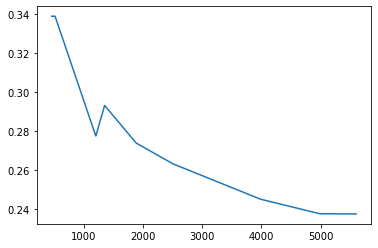

In [108]:
v = [ 6000,
    4992.512,
3996.452,
2519.6536,
1890.0615,
1352.2175,
1203.1013,
517.1026,
0]

LoD = [0.2375,
    0.23756167,
0.24493533,
0.26297614,
0.27370104,
0.29312414,
0.27746123,
0.33886394,
0.33886]

lodfun = interp1d(v, LoD)
V = np.linspace(5600,460, 5000)
plt.plot(V, lodfun(V))

In [109]:
## Linear estimates via DA 
mass = data['mass']
x0 = np.append(data['mean'].T[0], mass)
x0[[1,2]] = x0[[2,1]]
Vf = data['v'][-1]
V0 = data['v'][0]

P0 = np.zeros((4,4))
Vars = np.diag(data['input']['P0']).copy()
Vars[[1,2]] = Vars[[2,1]]
P0[:3, :3] =   np.diag(Vars)# h fpa s (no velocity term) 
# FIX: covariances are in different order than states
names = ['r', 's', 'fpa', 'm']
x0d = da.make(x0, names, 1)
du = da.make([0], 'u', 1)[0]
dL = da.make([0], 'L', 1)[0]
dD = da.make([0], 'D', 1)[0]
drho = da.make([0], 'rho', 1)[0]
params = ['L','D','rho']
vehicle = ConstantAeroEV(1.408, 0.357)
model = Entry(VehicleModel=vehicle, DifferentialAlgebra=True, Velocity=True, Longitudinal=True)
controller = ddp_controller(data, sat=True, safe=False)

X = [x0d]
V = V0.copy()
N = 1000
dv = (Vf-V0)/(N-1)
print(V0, Vf, dv)
for i in range(N-1):
#     print(i, X[-1])
    rho,a = model.planet.atmosphere(X[-1][0])
    rho *= (1+drho)
    LoD = lodfun(V)
    D = 0.5*rho * V**2 * data['area']/mass * 1.46*(1+dD) # cd = 1.46;
    L = LoD*(1+dL)*D
#     print(LoD)
    u = controller(V, X[-1], L, D, saturate=True) + du 
#     print(u)
    x = RK4(model.dynamics((u, [], [])), X[-1], np.linspace(V, V+dv, 5).squeeze(), ())[-1]
    X.append(x)
    V += dv

STM = da.jacobian(X[-1], names + params)
STM = np.vstack([STM, np.hstack([np.zeros((3,4)), np.eye(3)])])
P_param = np.diag([5/100, 5/100, 7/100])**2
P0_total = np.vstack([np.hstack([P0,np.zeros((4,3))]), np.hstack([np.zeros((3,4)),P_param])])

P = STM.dot(P0_total).dot(STM.T)
S = np.diag(P)**0.5

print("Mean Altitude\nLinear: {:.3f}".format((X[-1][0].constant_cf/1000)))
print("Sigma altitude\nLinear: {:.3f}".format(S[0]/1000))
print("Mean range \nLinear: {:.3f}".format(X[-1][1].constant_cf/1000))
print("Sigma range error\nLinear: {:.3f}".format(S[1]/1000))

Fixed Gain Controller,  [0 0 0]
5461.4 459.9999999999636 -5.006406406406443
Mean Altitude
Linear: 10.562
Sigma altitude
Linear: 0.237
Mean range 
Linear: 303.137
Sigma range error
Linear: 25.740


In [ ]:
# r s gamma (m) u 
# da.jacobian(X[-1], names+['u']) # 4 x 6 matrix 

submatrix(da.jacobian(X[-1], names+['u']), rows, cols)

In [ ]:
# Compute Apollo gains wrt to velocity?? 
rows = [0,1,2]
cols = rows + [-1] # get the derivs wrt controls too 
stm  = [np.vstack([submatrix(da.jacobian(x, names+['u']), rows, cols), np.eye(4)[-1]]) for x in X]

print(stm[-1])

# get adjoints 
dJdx = [-1.0/np.tan(X[-1][2].constant_cf), 1, 0, 0]
dJdx = [-1.0/np.tan(X[-1][2].constant_cf), 1, 0, 0]



stmi = [np.linalg.inv(st) for st in stm]
stmf = stm[-1]
C = np.dot(dJdx, stmf)
L = np.array([np.dot(C, si) for si in stmi])

In [ ]:
v = np.linspace(V0, Vf, N).squeeze()

plt.figure()
plt.plot(v[v>600], L[v>600])
plt.legend(['h','s','fpa','u'])
plt.grid(1)
plt.show()

plt.figure()
plt.title('Adjoints Scaled < 1')
plt.plot(v[v>600], L[v>600]/np.max(L[v>600],axis=0))
plt.legend(['h','s','fpa','u'])
plt.grid(1)
plt.show()

vmin = 1000
for i in [0,1,2]:
    plt.figure()
    plt.plot(v[v>vmin], L[v>vmin,i]/L[v>vmin,3])
#     plt.legend(['h','s','fpa'])
    plt.grid(1)
plt.show()

## Closed Loop

In [110]:
data= data_loader('UTExample_ClosedLoop')
MC = MonteCarlo(build_dict(data['sol']), N=5000, debug=False)
data = build_dict(data['sol'])


Weights: [0 0 0]
Downrange Target = 307.367 km
 
Generating 5000 samples...
 
Generating 5000 samples...
     Sobol sampling method
     Parametric uncertainty only
Fixed Gain Controller,  [ 0.072 -0.025 -4.   ]
1% altitude = 9.025 km
99% range error = 6.430 km
Mean range error = -0.91 km
Mean Altitude
	DDP: 11.988 km
	MC:  11.685 km
3-sigma Low Altitude
	DDP: 11.988 km
	MC:  8.872 km
3-sigma DR Error
	DDP: 0.000 km
	MC:  9.374 km


In [111]:
display(MC['table'][0])
display(MC['table'][1])

,mean,std,1%,99%
UT Altitude,11.987947,0.0,0.0,0.0
UT Range,307.367126,0.0,0.0,0.0


,mean,std,1%,99%
MC Altitude,11.685477,0.937958,9.024826,13.547628
MC Range,306.460996,3.124749,0.020356,6.429825


In [115]:
mass = data['mass']
x0 = np.append(data['mean'].T[0], mass)
x0[[1,2]] = x0[[2,1]]
Vf = data['v'][-1]
V0 = data['v'][0]

P0 = np.zeros((4,4))
Vars = np.diag(data['input']['P0']).copy()
Vars[[1,2]] = Vars[[2,1]]
P0[:3, :3] =   np.diag(Vars)# h fpa s (no velocity term) 
# FIX: covariances are in different order than states
names = ['r', 's', 'fpa', 'm']
x0d = da.make(x0, names, 1)
du = da.make([0], 'u', 1)[0]
dL = da.make([0], 'L', 1)[0]
dD = da.make([0], 'D', 1)[0]
drho = da.make([0], 'rho', 1)[0]
params = ['L','D','rho']
vehicle = ConstantAeroEV(1.408, 0.357)
model = Entry(VehicleModel=vehicle, DifferentialAlgebra=True, Velocity=True, Longitudinal=True)
controller = ddp_controller(data, sat=True, safe=False)

X = [x0d]
V = V0.copy()
N = 1000
dv = (Vf-V0)/(N-1)
print(V0, Vf, dv)
for i in range(N-1):
#     print(i, X[-1])
    rho,a = model.planet.atmosphere(X[-1][0])
    rho *= (1+drho)
    LoD = lodfun(V)
    D = 0.5*rho * V**2 * data['area']/mass * 1.46*(1+dD) # cd = 1.46;
    L = LoD*(1+dL)*D
#     print(da.const([L,D]))
    u = controller(V, X[-1], L, D, saturate=False) + du 
#     print(u)
    x = RK4(model.dynamics((u, [], [])), X[-1], np.linspace(V, V+dv, 5).squeeze(), ())[-1]
    X.append(x)
    V += dv

STM = da.jacobian(X[-1], names + params)
STM = np.vstack([STM, np.hstack([np.zeros((3,4)), np.eye(3)])])
P_param = np.diag([5/100, 5/100, 7/100])**2
P0_total = np.vstack([np.hstack([P0,np.zeros((4,3))]), np.hstack([np.zeros((3,4)),P_param])])
P0_total[0,0] = 0
P = STM.dot(P0_total).dot(STM.T)
S = np.diag(P)**0.5
print("\nUnsaturated control")
print("Mean Altitude\nLinear: {:.3f}".format((X[-1][0].constant_cf/1000)))
print("Sigma altitude\nLinear: {:.3f}".format(S[0]/1000))
print("Mean range \nLinear: {:.3f}".format(X[-1][1].constant_cf/1000))
print("Sigma range error\nLinear: {:.3f}".format(S[1]/1000))

# With saturating the control
X = [x0d]
V = V0.copy()
N = 1000
dv = (Vf-V0)/(N-1)
print(V0, Vf, dv)
for i in range(N-1):
#     print(i, X[-1])
    rho,a = model.planet.atmosphere(X[-1][0])
    rho *= (1+drho)
    LoD = lodfun(V)
    D = 0.5*rho * V**2 * data['area']/mass * 1.46*(1+dD) # cd = 1.46;
    L = LoD*(1+dL)*D
    u = controller(V, X[-1], L, D, saturate=True) + du 
#     print(u)
    x = RK4(model.dynamics((u, [], [])), X[-1], np.linspace(V, V+dv, 5).squeeze(), ())[-1]
    X.append(x)
    V += dv

STM = da.jacobian(X[-1], names + params)
STM = np.vstack([STM, np.hstack([np.zeros((3,4)), np.eye(3)])])
P_param = np.diag([5/100, 5/100, 7/100])**2
P0_total = np.vstack([np.hstack([P0,np.zeros((4,3))]), np.hstack([np.zeros((3,4)),P_param])])
P0_total[0,0] = 0
P = STM.dot(P0_total).dot(STM.T)
S = np.diag(P)**0.5
print("\nSaturated control")
print("Mean Altitude\nLinear: {:.3f}".format((X[-1][0].constant_cf/1000)))
print("Sigma altitude\nLinear: {:.3f}".format(S[0]/1000))
print("Mean range \nLinear: {:.3f}".format(X[-1][1].constant_cf/1000))
print("Sigma range error\nLinear: {:.3f}".format(S[1]/1000))


Fixed Gain Controller,  [ 0.072 -0.025 -4.   ]
5461.4 459.9999999999636 -5.006406406406443

Unsaturated control
Mean Altitude
Linear: 10.948
Sigma altitude
Linear: 0.293
Mean range 
Linear: 303.159
Sigma range error
Linear: 3.016
5461.4 459.9999999999636 -5.006406406406443

Saturated control
Mean Altitude
Linear: 10.742
Sigma altitude
Linear: 0.189
Mean range 
Linear: 302.807
Sigma range error
Linear: 3.270


In [119]:
STM = da.jacobian(X[-1], names + params)
STM = np.vstack([STM, np.hstack([np.zeros((3,4)), np.eye(3)])])
P_param = np.diag([5/100, 5/100, 7/100])**2
P0_total = np.vstack([np.hstack([P0,np.zeros((4,3))]), np.hstack([np.zeros((3,4)),P_param])])
P0_total[0,0] = 0.1
P = STM.dot(P0_total).dot(STM.T)
S = np.diag(P)**0.5
print("\nSaturated control")
print("Mean Altitude\nLinear: {:.3f}".format((X[-1][0].constant_cf/1000)))
print("Sigma altitude\nLinear: {:.3f}".format(S[0]/1000))
print("Mean range \nLinear: {:.3f}".format(X[-1][1].constant_cf/1000))
print("Sigma range error\nLinear: {:.3f}".format(S[1]/1000))


Saturated control
Mean Altitude
Linear: 10.742
Sigma altitude
Linear: 1.096
Mean range 
Linear: 302.807
Sigma range error
Linear: 17.296


In [104]:
for x in X[10]:
    display(x) 

-0.563438*dm+37749.3+10.1547*du+8484.38*dfpa+22.1161*dD-0.000253867*ds+22.9448*dr-3.57309*dL

-1.43616*dL+3.04175*dm+4.08699*du+4957.47*dfpa+8.79253*dD+0.999898*ds+9.70324*dr+9137.18

0.00532069*dD+0.988756*dfpa+0.00237643*du+5.86958e-07*dm-0.182877-0.000838758*dL+0.0053203*dr-5.94107e-08*ds

dm+2804

In [103]:
np.diag(P0_total)**0.5

array([ 2500.   , 10000.   ,     0.004,     0.   ,     0.05 ,     0.05 ,
           0.07 ])